<h1 align="center">Multiple Linear Regression to Assess Customer Tenure</h1> 
<center>
Kelseyann Wright </br>

<h2>Data Cleaning & Data Transformation</h2>

In [1]:
#import all necessary libraries and set up workspace
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
import sklearn.metrics as metrics
from sklearn import preprocessing
from sklearn import svm
from sklearn import feature_selection as featsel


pd.set_option('display.max_columns', None)

In [2]:
#load data, check for nulls and duplicates
dat = pd.read_csv("~/Desktop/WGU/D208/churn_clean.csv") #load data CSV
print("number of duplicates:", dat.duplicated().sum()) #count and print number of duplicates
print("number of nulls:", dat.isna().sum().sum())

#remove object columns with high cardinality (more than 5 groups)
uniqueVal = dat.select_dtypes(include='object').nunique()
cardcols = uniqueVal[uniqueVal>5].index
datmod=dat
datmod.drop(list(cardcols), inplace=True, axis=1) 
datmod.drop(['CaseOrder', 'Zip', 'Item1', 'Item2', 'Item3', 'Item4', 'Item5', 'Item6', 'Item7', 'Item8'], inplace=True, axis=1)

number of duplicates: 0
number of nulls: 0


In [3]:
#replace yes/no with 1/0
obj_cols = datmod.select_dtypes(include=['object']).columns
for i in obj_cols:
    datmod = datmod.replace({i: {'Yes': 1, 'No': 0}}) #replace yes / no cols with 1 / 0

#create dummy variables for other object columns
obj_cols = datmod.select_dtypes(include=['object']).columns #define remaining object columns
datmod = pd.get_dummies(datmod, columns=obj_cols) #create dummy variables
datmod.head()

,Lat,Lng,Population,Children,Age,Income,Churn,Outage_sec_perweek,Email,Contacts,Yearly_equip_failure,Techie,Port_modem,Tablet,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,Tenure,MonthlyCharge,Bandwidth_GB_Year,Area_Rural,Area_Suburban,Area_Urban,Marital_Divorced,Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Gender_Female,Gender_Male,Gender_Nonbinary,Contract_Month-to-month,Contract_One year,Contract_Two Year,InternetService_DSL,InternetService_Fiber Optic,InternetService_None,PaymentMethod_Bank Transfer(automatic),PaymentMethod_Credit Card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check
0,56.25100,-133.37571,38,0,68,28561.99,0,7.978323,10,0,1,0,1,1,1,0,1,1,0,0,0,1,1,6.795513,172.455519,904.536110,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0
1,44.32893,-84.24080,10446,1,27,21704.77,1,11.699080,12,0,1,1,0,1,1,1,1,0,0,0,1,1,1,1.156681,242.632554,800.982766,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0
2,45.35589,-123.24657,3735,4,50,9609.57,0,10.752800,9,0,1,1,1,0,1,1,0,0,0,0,0,1,1,15.754144,159.947583,2054.706961,0,0,1,0,0,0,0,1,1,0,0,0,0,1,1,0,0,0,1,0,0
3,32.96687,-117.24798,13863,1,48,18925.23,0,14.913540,15,2,0,1,0,0,1,0,1,0,0,0,1,0,1,17.087227,119.956840,2164.579412,0,1,0,0,1,0,0,0,0,1,0,0,0,1,1,0,0,0,0,0,1
4,29.38012,-95.80673,11352,0,83,40074.19,1,8.147417,16,2,1,0,1,0,0,0,0,0,0,1,1,0,0,1.670972,149.948316,271.493436,0,1,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,0,0,1


In [4]:
datmod['Churn'] = datmod['Churn'].astype('category')
datmod.iloc[:,11:23] = datmod.iloc[:,11:23].astype('category')
datmod.iloc[:,26:47] = datmod.iloc[:,26:47].astype('category')
#datmod.info()

In [5]:
num_cols = datmod.select_dtypes(include=[np.number])
rsq = num_cols.corr()['Tenure']**2 #calculate R2
rsq[rsq > 0.3]

Tenure               1.000000
Bandwidth_GB_Year    0.983063
Name: Tenure, dtype: float64

In [6]:
cat_cols = datmod.select_dtypes(include=['category']).columns
for x in cat_cols:
    #define samples
    group1 = datmod[datmod[x]==0]
    group2 = datmod[datmod[x]==1]

    #perform independent two sample t-test
    results = stats.ttest_ind(group1['Tenure'], group2['Tenure'])
    if results.pvalue < 0.1:
        print(x, results.pvalue)

Churn 0.0
OnlineBackup 0.03751469572862576
DeviceProtection 0.004930196548247493
Area_Rural 0.09861934925789437
Contract_Two Year 0.05124601648442537


In [7]:
datmod = datmod.loc[:, ['Tenure', 
               'Bandwidth_GB_Year', 
               'Churn', 
               'OnlineBackup', 
               'DeviceProtection', 
               'Area_Rural', 
               'Area_Suburban', 
               'Area_Urban',
              'Contract_Month-to-month', 
               'Contract_One year',
               'Contract_Two Year']]
datmod.columns = ['Tenure', 
               'Bandwidth_GB_Year', 
               'Churn', 
               'OnlineBackup', 
               'DeviceProtection', 
               'Area_Rural', 
               'Area_Suburban', 
               'Area_Urban',
              'Contract_MonthToMonth', 
               'Contract_OneYear',
               'Contract_TwoYear']
datmod.to_csv("~/Desktop/WGU/D208/churn_model_data_T1.csv")
datmod.head()

,Tenure,Bandwidth_GB_Year,Churn,OnlineBackup,DeviceProtection,Area_Rural,Area_Suburban,Area_Urban,Contract_MonthToMonth,Contract_OneYear,Contract_TwoYear
0,6.795513,904.536110,0,1,0,0,0,1,0,1,0
1,1.156681,800.982766,1,0,0,0,0,1,1,0,0
2,15.754144,2054.706961,0,0,0,0,0,1,0,0,1
3,17.087227,2164.579412,0,0,0,0,1,0,0,0,1
4,1.670972,271.493436,1,0,0,0,1,0,1,0,0


<h2>Summary Statistics</h2>

In [8]:
datmod.describe()

,Tenure,Bandwidth_GB_Year
count,10000.000000,10000.000000
mean,34.526188,3392.341550
std,26.443063,2185.294852
min,1.000259,155.506715
25%,7.917694,1236.470827
50%,35.430507,3279.536903
75%,61.479795,5586.141370
max,71.999280,7158.981530


In [9]:
dat_cat = dat.loc[:, ['Churn', 'OnlineBackup', 'DeviceProtection', 'Area', 'Contract']]
dat_cat.columns = ['Churn', 'OnlineBackup', 'DeviceProtection', 'Area', 'Contract']

for col in dat_cat.columns:
    print(col)
    print(dat[col].value_counts())
    print()

Churn
No     7350
Yes    2650
Name: Churn, dtype: int64

OnlineBackup
No     5494
Yes    4506
Name: OnlineBackup, dtype: int64

DeviceProtection
No     5614
Yes    4386
Name: DeviceProtection, dtype: int64

Area
Suburban    3346
Urban       3327
Rural       3327
Name: Area, dtype: int64

Contract
Month-to-month    5456
Two Year          2442
One year          2102
Name: Contract, dtype: int64



<h2>Visualizations</h2>

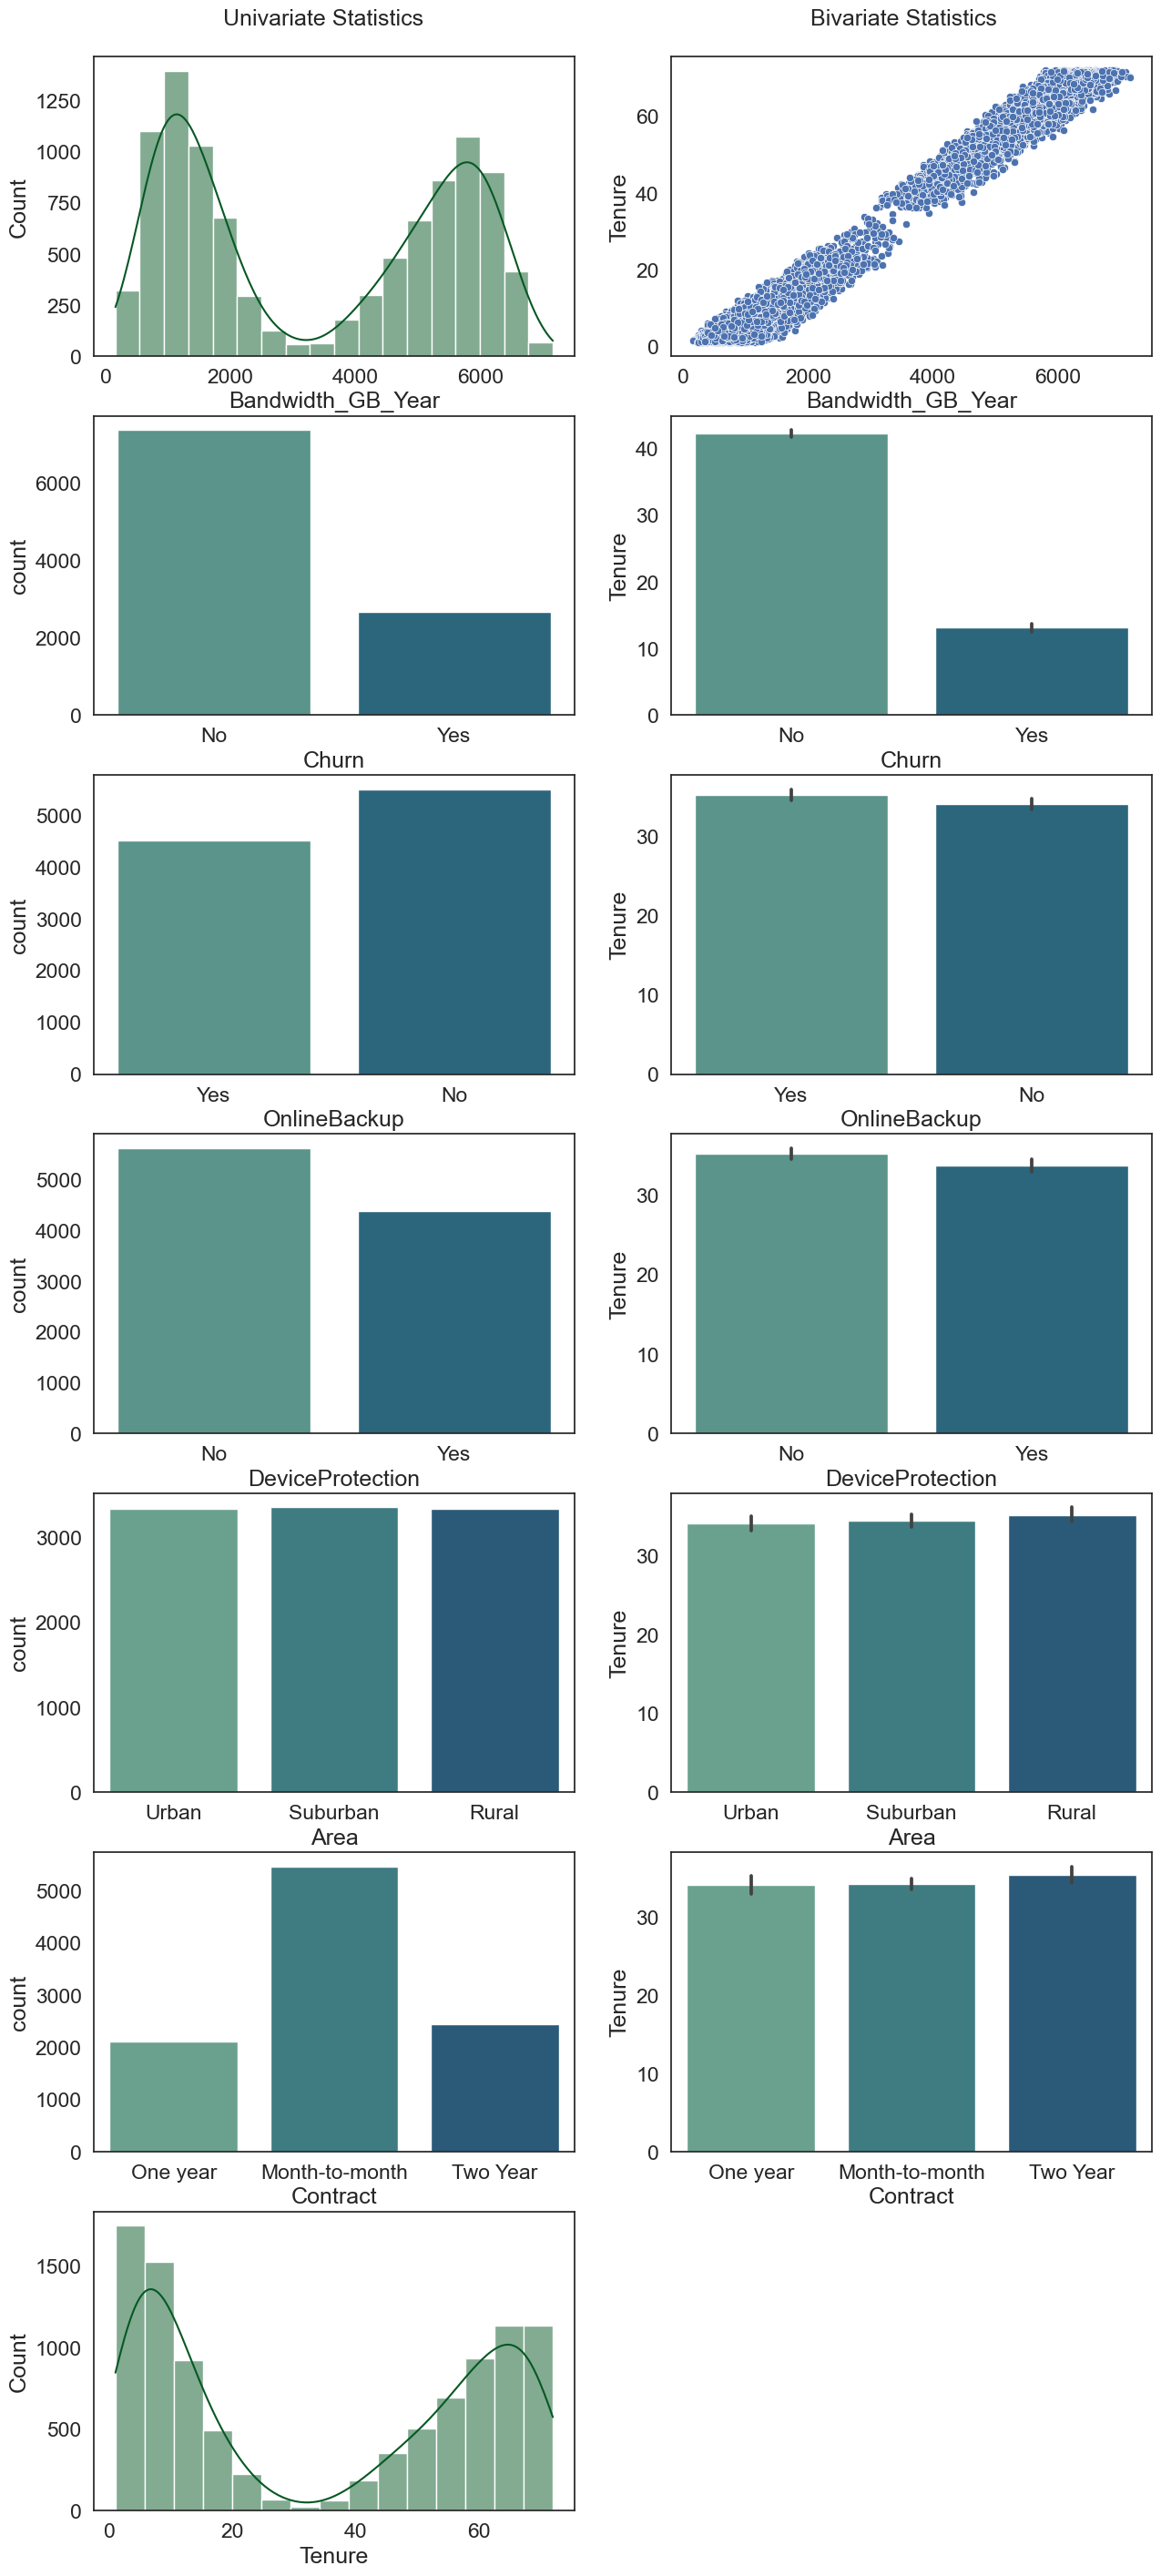

In [10]:
sns.set(font_scale=1.5)
sns.set_style("white")
fig, axes = plt.subplots(7, 2, figsize=(15, 35), sharey=False, sharex=False)

c1 = sns.histplot(data=dat, x='Bandwidth_GB_Year', kde=True, color = '#065824', ax=axes[0,0])
c2 = sns.scatterplot(data=dat, y='Tenure', x="Bandwidth_GB_Year", ax=axes[0,1])

c3 = sns.countplot(data=dat, x="Churn", palette="crest", ax=axes[1,0])
c4 = sns.barplot(data=dat, y='Tenure', x="Churn", palette="crest", ax=axes[1,1])

c5 = sns.countplot(data=dat, x="OnlineBackup", palette="crest", ax=axes[2,0])
c6 = sns.barplot(data=dat, y='Tenure', x="OnlineBackup", palette="crest", ax=axes[2,1])

c7 = sns.countplot(data=dat, x="DeviceProtection", palette="crest", ax=axes[3,0])
c8 = sns.barplot(data=dat, y='Tenure', x="DeviceProtection", palette="crest", ax=axes[3,1])

c9 = sns.countplot(data=dat, x="Area", palette="crest", ax=axes[4,0])
c10 = sns.barplot(data=dat, y='Tenure', x="Area", palette="crest", ax=axes[4,1])

c11 = sns.countplot(data=dat, x="Contract", palette="crest", ax=axes[5,0])
c12 = sns.barplot(data=dat, y='Tenure', x="Contract", palette="crest", ax=axes[5,1])

c13 = sns.histplot(data=dat, x='Tenure', kde=True, color = '#065824', ax=axes[6,0])

plt.delaxes(axes[6,1])

plt.figtext(0.22, 0.89, 'Univariate Statistics')
plt.figtext(0.65, 0.89, 'Bivariate Statistics')

#plt.tight_layout()
plt.show()

<h2>Initial Model</h2>
The submission provides an accurate initial multiple linear regression model from all independent variables identified in part C2.

In [11]:
#standardize all data to Gaussian normal distributions
scaler = preprocessing.StandardScaler()
datstd = pd.DataFrame(scaler.fit_transform(datmod), columns = datmod.columns)

# create model variables
Xmod = datstd.drop('Tenure',axis= 1) #predictor (independent) variables
Ymod = datstd['Tenure'] #dependent variable
scaleX_mod = np.delete(scaler.scale_, 0) #create scaler list for unscaling the coefficients

R2:   0.9869573280747745
RMSE_test:  0.11454857023590062
RMSE_train:  0.11523084660950667
RMSE_diff:   0.0006822763736060444
                       Coefficients_scaled  Coefficents_orig
Bandwidth_GB_Year             9.653887e-01      4.417880e-04
Churn                        -6.140802e-02     -1.391421e-01
OnlineBackup                 -1.597641e-02     -3.210992e-02
DeviceProtection             -1.610593e-02     -3.245752e-02
Area_Rural                    1.174859e+10      2.493440e+10
Area_Suburban                 1.176531e+10      2.493440e+10
Area_Urban                    1.174859e+10      2.493440e+10
Contract_MonthToMonth         6.200495e+11      1.245289e+12
Contract_OneYear              5.073936e+11      1.245289e+12
Contract_TwoYear              5.349908e+11      1.245289e+12


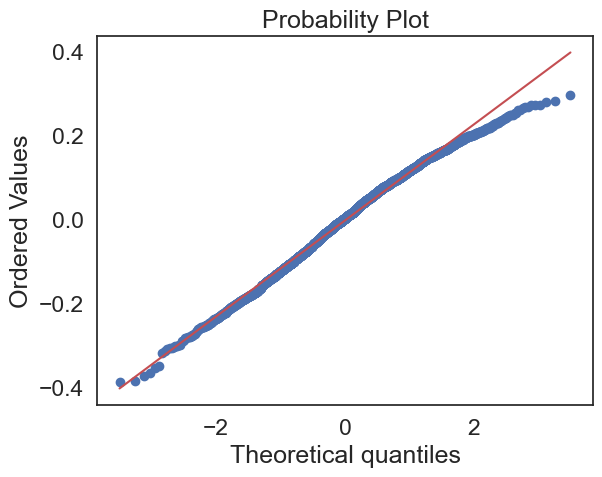

In [12]:
#define linear regression function
def lin_reg(X, y, scaleX):  
    # creating train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

    model = LinearRegression() # creating model
    model.fit(X_train,y_train) # fitting the model
    predict_test = model.predict(X_test) #make predictions on test data
    predict_train = model.predict(X_train) #make predictions from training data

    print('R2:  ' , metrics.r2_score(y_test, predict_test)) #print R2
    
    #compare RMSE of test and train data to make sure data was not overfit to training set
    print('RMSE_test: ', np.sqrt(metrics.mean_squared_error(y_test, predict_test)))
    print('RMSE_train: ', np.sqrt(metrics.mean_squared_error(y_train, predict_train)))
    print('RMSE_diff:  ', abs(np.sqrt(metrics.mean_squared_error(y_train, predict_train)) - np.sqrt(metrics.mean_squared_error(y_test, predict_test))))
    
    #print regression coefficients
    coefficients = pd.DataFrame({'Coefficients_scaled':model.coef_, 'Coefficents_orig':np.true_divide(model.coef_,  scaleX)}, index=X_test.columns)
    print(coefficients)
    
    #calculate residuals
    residuals = y_test-predict_test
    #sns.histplot(residuals)
    ax = stats.probplot(residuals, dist="norm", plot=plt)
    plt.show()
    
lin_reg(Xmod, Ymod, scaleX_mod) #run model

In [29]:
def cross_validation(X, y):
    model = LinearRegression() # creating model
    score = cross_val_score(model, X, y,cv=5, scoring="r2")
    print('R_squared Mean Score:',score.mean())
    print(score)
    
cross_validation(Xmod,Ymod)

R_squared Mean Score: 0.8460489023543186
[0.75019005 0.77308548 0.98653268 0.86185845 0.85857786]


<h2>Model Reduction</h2>

In [30]:
datstd.head()

,Tenure,Bandwidth_GB_Year,Churn,OnlineBackup,DeviceProtection,Area_Rural,Area_Suburban,Area_Urban,Contract_MonthToMonth,Contract_OneYear,Contract_TwoYear
0,-1.048746,-1.138487,-0.600453,1.104203,-0.88389,-0.706099,-0.709123,1.416231,-1.095767,1.938395,-0.568420
1,-1.262001,-1.185876,1.665408,-0.905631,-0.88389,-0.706099,-0.709123,1.416231,0.912603,-0.515891,-0.568420
2,-0.709940,-0.612138,-0.600453,-0.905631,-0.88389,-0.706099,-0.709123,1.416231,-1.095767,-0.515891,1.759262
3,-0.659524,-0.561857,-0.600453,-0.905631,-0.88389,-0.706099,1.410193,-0.706099,-1.095767,-0.515891,1.759262
4,-1.242551,-1.428184,1.665408,-0.905631,-0.88389,-0.706099,1.410193,-0.706099,0.912603,-0.515891,-0.568420


In [42]:
#Use RFE to remove not significant features from the initial model
selector = featsel.RFE(svm.SVR(kernel="linear"), step=1)
selector = selector.fit(Xmod, Ymod)

#Test new model
#New features dataframe containing only selected features through RFE
X_RFE = Xmod[Xmod.columns[selector.support_]]

R2:   0.986974408103286
RMSE_test:  0.11447354213553336
RMSE_train:  0.11525691582571283
RMSE_diff:   0.000783373690179473
                       Coefficients_scaled  Coefficents_orig
Bandwidth_GB_Year                 0.965253          0.000442
Churn                            -0.061702         -0.139809
OnlineBackup                     -0.015968         -0.032094
DeviceProtection                 -0.016050         -0.032345
Contract_MonthToMonth             0.018628          0.037412


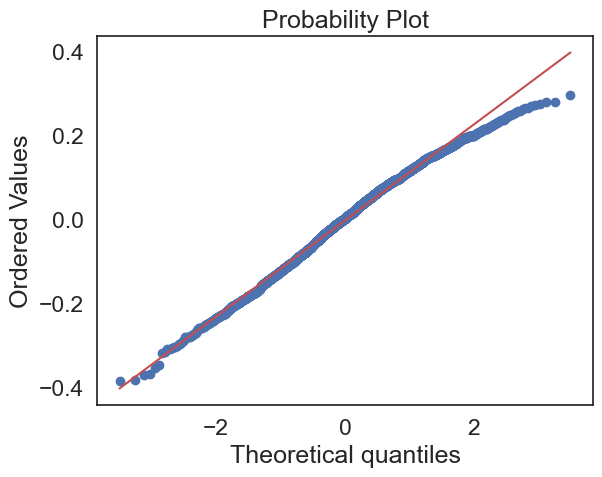

In [49]:
scaleX_RFE = scaleX_mod[selector.support_] #define new scaler list for unscaling coefficients
lin_reg(X_RFE, Ymod, scaleX_RFE)

In [15]:
cross_validation(X_RFE,Ymod)

R_squared Mean Score: 0.8462050857376727
[0.75041862 0.77332464 0.98654558 0.86182812 0.85890848]


In [16]:
model_final = sm.OLS(Ymod, X_RFE).fit()
model_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 Tenure   R-squared (uncentered):                   0.987
Model:                            OLS   Adj. R-squared (uncentered):              0.987
Method:                 Least Squares   F-statistic:                          1.491e+05
Date:                Mon, 17 Apr 2023   Prob (F-statistic):                        0.00
Time:                        05:05:16   Log-Likelihood:                          7437.9
No. Observations:               10000   AIC:                                 -1.487e+04
Df Residuals:                    9995   BIC:                                 -1.483e+04
Df Model:                           5                                                  
Covariance Type:            nonrobust                                                  
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Bandwidth_GB_Year         0.9646      0.001    744.683      0.000       0.962       0.967
Churn                    -0.0628      0.001    -46.600      0.000      -0.065      -0.060
OnlineBackup             -0.0162      0.001    -14.041      0.000      -0.018      -0.014
DeviceProtection         -0.0168      0.001    -14.579      0.000      -0.019      -0.015
Contract_MonthToMonth     0.0190      0.001     15.827      0.000       0.017       0.021
==============================================================================
Omnibus:                      229.770   Durbin-Watson:                   1.963
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              170.965
Skew:                          -0.226   Prob(JB):                     7.51e-38
Kurtosis:                       2.546   Cond. No.                         1.78
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""